A script for loading in tendencies (temperature or salinity) from FAFMIP experiments from the data available on NCI as at 21/04/22. These tendencies are then binned into watermass coordinates, with a focus on temperature-depth or salinity-depth, but the script should be easily adaptable (see the tendency_term_binning function in particular) to other coordinate choices (e.g, temperature-latitude, salinity-latitude).

I also apologise in advance to any future readers who happen also to be Python aficionados... My code is surely quite inelegant (https://peps.python.org/pep-0008/), but I ask for your forgiveness: I am but a humble auto-didact!

In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
import pandas as pd
import netCDF4 as nc

# For the binning
from xhistogram.xarray import histogram 

# For regridding from tripolar to regular grid (MRI-ESM2-0 -- since some variables are provided on the native grid, others have already been regridded):
# https://earth-env-data-science.github.io/lectures/working_with_gcm_data.html
import xesmf as xe

In [3]:
path_fs38 = '/g/data/fs38/publications/CMIP6/FAFMIP/' # For ACCESS-CM2
path_oi10 = '/g/data/oi10/replicas/CMIP6/FAFMIP/'     # For models not ACCESS-CM2

In [4]:
def load_faf_expt_tendencies(model_name, faf_expt_name, variable_type):
    '''
    DESCRIPTION:
    ---
    Load in either temperature or salinity tendency terms from any FAFMIP experiment run currently available on /g/data.
    All the tendency terms are annual averages.
    ---
    OPTIONS:
    ---
    model_name:      'ACCESS-CM2', 'CAS-ESM2-0', 'CanESM5', 'FGOALS-g3', 'MIROC6', 'MPI-ESM1-2-HR', 'MRI-ESM2-0', 'CESM2', 'GFDL-ESM2M'
    faf_expt_name:   'faf-passiveheat', 'faf-heat', 'faf-all', 'faf-water', 'faf-stress'
    variable_type:   'temperature', 'salinity'
    ---
    '''
    
    ### Match model_name to modelling_group ###
    
    if model_name == 'ACCESS-CM2':
        modelling_group = 'CSIRO-ARCCSS'
    elif model_name == 'CAS-ESM2-0':
        modelling_group = 'CAS'
    elif model_name == 'CanESM5':
        modelling_group = 'CCCma'
    elif model_name == 'FGOALS-g3':
        modelling_group = 'CAS'
    elif model_name == 'MIROC6':
        modelling_group = 'MIROC'
    elif model_name == 'MPI-ESM1-2-HR':
        modelling_group = 'MPI-M'
    elif model_name == 'MRI-ESM2-0':
        modelling_group = 'MRI'
    elif model_name == 'CESM2':
        modelling_group = 'NCAR'
    elif model_name == 'GFDL-ESM2M':
        modelling_group = 'NOAA-GFDL'
    
    
    ### Define path to FAFMIP experiments ###
    
    if model_name == 'ACCESS-CM2':
        model_path = path_fs38 + modelling_group + '/' + model_name + '/'
    else:
        model_path = path_oi10 + modelling_group + '/' + model_name + '/'
        
    expt_path = model_path + faf_expt_name + '/*/'

    
    ### Get grid information ###
    
    # Area:
    try:
        if model_name == 'ACCESS-CM2':
            areacello = xr.open_mfdataset(expt_path + 'Ofx/areacello/gn/latest/*.nc')['areacello']
        elif model_name == 'CAS-ESM2-0':
            areacello = xr.open_mfdataset('/g/data/oi10/replicas/CMIP6/CMIP/CAS/CAS-ESM2-0/historical/r1i1p1f1/Ofx/areacello/gn/v20201228/areacello_Ofx_CAS-ESM2-0_historical_r1i1p1f1_gn.nc')['areacello']
        elif model_name == 'GFDL-ESM2M':
            areacello = xr.open_mfdataset('/g/data/oi10/replicas/CMIP6/FAFMIP/NOAA-GFDL/GFDL-ESM2M/faf-passiveheat/r1i1p1f1/Ofx/areacello/gn/v20180701/*.nc')['areacello']
        else:
            areacello = xr.open_mfdataset(expt_path + 'Ofx/areacello/gn/*/*.nc')['areacello']
    except:
        areacello = np.empty(0)
        print('areacello for ' + model_name + ' not found')
    
    # Volume: 
    try:
        if model_name == 'ACCESS-CM2':
            volcello = xr.open_mfdataset(expt_path + 'Omon/volcello/gn/latest/*.nc')['volcello'].groupby('time.year').mean(dim='time', keep_attrs=True)
        else:
            volcello = xr.open_mfdataset(expt_path + 'Omon/volcello/gn/*/*.nc')['volcello'].groupby('time.year').mean(dim='time', keep_attrs=True)
    except:
        volcello = np.empty(0)
        print('volcello for ' + model_name + ' not found')
        
    
    ### Get available variables for given model_name and given variable_type ###
    
    variables = [] # List of FAFMIP tendency variables to return at end of function.
    
    tendency_names = ['tend', 'rmadvect', 'padvect', 'psmadvect', 'pmdiff', 'diff']
    
    
    def surface_flux_term(surface_flux, coord):
        '''
        DESCRIPTION:
        ---
        The net surface heat flux term (hfds) or net surface water flux (wfo)
        is defined in the surface layer, but it is not given nice, 'lev' dimensions.
        Here, I add level dimensions to give a DataArray with the surface flux 
        value in the surface layer and zero below
        ---
        OPTIONS:
        ---
        surface_flux:   Either hfds or wfo
        coord:          Either 4D temperature or 4D salinity
        ---
        '''
    
        surface_flux_attrs = np.array([surface_flux.attrs['standard_name'],
                               surface_flux.attrs['long_name'],
                               surface_flux.attrs['units']])
    
        surface_flux = surface_flux.expand_dims({'lev': 1}).assign_coords({'lev': [coord.lev.values[0]]})
    
        surface_flux = xr.concat([surface_flux, xr.zeros_like(coord.isel(lev=slice(1,None)))], dim='lev')
    
        surface_flux.attrs.update({'standard_name': f'{surface_flux_attrs[0]}',
                    'long_name': f'{surface_flux_attrs[1]}',
                      'units': f'{surface_flux_attrs[2]}'})
    
        return surface_flux
    
    ### TEMPERATURE ###
    
    if variable_type == 'temperature':
        
        if model_name == 'ACCESS-CM2':
            # different path ending...!
            
            temperature_type = 'ocontemp'
            temp = xr.open_mfdataset(expt_path + 'Omon/bigthetao/gn/latest/*.nc')['bigthetao'].groupby('time.year').mean(dim='time', keep_attrs=True) # Temperature
            variables.append(temp)
            
            for name in tendency_names:
                try:
                    variables.append(xr.open_mfdataset(expt_path + 'Oyr/' + temperature_type + name + '/gn/latest/*.nc')[temperature_type + name].groupby('time.year').mean(dim='time', keep_attrs=True)) # Tendency terms
                except:
                    variables.append(np.empty(0))
                    print(temperature_type + name + ' term for ' + model_name + ' not found')
                    
            try:
                variables.append(xr.open_mfdataset(expt_path + 'Oyr/rsdoabsorb/gn/latest/*.nc')['rsdoabsorb'].groupby('time.year').mean(dim='time', keep_attrs=True)) # Shortwave absorption
            except:
                variables.append(np.empty(0))
                print('rsdoabsorb term for ' + model_name + ' not found')
                    
            try:
                hfds = xr.open_mfdataset(expt_path + 'Omon/hfds/gn/latest/*.nc')['hfds'].groupby('time.year').mean(dim='time', keep_attrs=True) # Net surface heat flux
                hfds = surface_flux_term(hfds, temp) # Add level dimensions: flux at surface, zero elsewhere                                                      
                variables.append(hfds)
            except:
                variables.append(np.empty(0))
                print('hfds term for ' + model_name + ' not found')
            
                
        
        elif model_name == 'MRI-ESM2-0':
            # path has 'gr' instead of 'gn' for monthly variables...!
            # tripolar grid for tendency terms also needs to be regridded (temperature has already been regridded...)
            
            temperature_type = 'opottemp'
            temp = xr.open_mfdataset(expt_path + 'Omon/thetao/gr/*/*.nc')['thetao'].groupby('time.year').mean(dim='time', keep_attrs=True)
            variables.append(temp)
                        
            # Regrid area for MRI:
            regridder = xe.Regridder(areacello, temp, 'bilinear', periodic=True)
            areacello = regridder(areacello, keep_attrs=True)
            
                    
            for name in tendency_names:
                try:
                    tend = xr.open_mfdataset(expt_path + 'Oyr/' + temperature_type + name + '/gn/*/*.nc')[temperature_type + name].groupby('time.year').mean('time', keep_attrs=True)
                    regridder = xe.Regridder(tend, temp, 'bilinear', periodic=True) # regrid the tripolar grid onto the same regular grid of temperature
                    tend_regridded = regridder(tend, keep_attrs=True)
                    variables.append(tend_regridded)
                    
                except:
                    variables.append(np.empty(0))
                    print(temperature_type + name + ' term for ' + model_name + ' not found')
            
            try:
                rsdoabsorb = xr.open_mfdataset(expt_path + 'Oyr/rsdoabsorb/gn/*/*.nc')['rsdoabsorb'].groupby('time.year').mean(dim='time', keep_attrs=True)
                regridder = xe.Regridder(rsdoabsorb, temp, 'bilinear', periodic=True) # regrid the tripolar grid onto the same regular grid of temperature
                rsdoabsorb_regridded = regridder(rsdoabsorb, keep_attrs=True)
                variables.append(rsdoabsorb_regridded) # Shortwave absorption
            except:
                variables.append(np.empty(0))
                print('rsdoabsorb term for ' + model_name + ' not found')
                
            
            try:
                hfds = xr.open_mfdataset(expt_path + 'Omon/hfds/gr/*/*.nc')['hfds'].groupby('time.year').mean(dim='time', keep_attrs=True) # Net surface heat flux
                hfds = surface_flux_term(hfds, temp) # Add level dimensions: flux at surface, zero elsewhere                                                      
                variables.append(hfds)
            except:
                variables.append(np.empty(0))
                print('hfds term for ' + model_name + ' not found')
         
        
        
        else:
            temperature_type = 'opottemp'
            
            if model_name == 'CAS-ESM2-0':
                # CAS-ESM2-0 has different year start time than all its tendency terms... offsetting the dimensions to fix this - for xarray operationn purposes only.
                temp = xr.open_mfdataset(expt_path + 'Omon/thetao/gn/*/*.nc')['thetao'].groupby('time.year').mean(dim='time', keep_attrs=True)
                temp['year'] = temp['year'] - temp['year'][0] + 1
                variables.append(temp)
                
            if model_name == 'MIROC6':
                # MIROC6 temperature field starts a year earlier than the advective terms... Cut off the first year. 
                temp = xr.open_mfdataset(expt_path + 'Omon/thetao/gn/*/*.nc')['thetao'].groupby('time.year').mean(dim='time', keep_attrs=True)
                temp = temp.isel(year=slice(1,None))
                variables.append(temp)
             
            else:
                temp = xr.open_mfdataset(expt_path + 'Omon/thetao/gn/*/*.nc')['thetao'].groupby('time.year').mean(dim='time', keep_attrs=True)
                variables.append(temp)
                
                
            for name in tendency_names:
                try:
                    variables.append(xr.open_mfdataset(expt_path + 'Oyr/' + temperature_type + name + '/gn/*/*.nc')[temperature_type + name].groupby('time.year').mean('time', keep_attrs=True))
                except:
                    variables.append(np.empty(0))
                    print(temperature_type + name + ' term for ' + model_name + ' not found')
                    
            try:
                variables.append(xr.open_mfdataset(expt_path + 'Oyr/rsdoabsorb/gn/*/*.nc')['rsdoabsorb'].groupby('time.year').mean(dim='time', keep_attrs=True)) # Shortwave absorption
            except:
                variables.append(np.empty(0))
                print('rsdoabsorb term for ' + model_name + ' not found')
            
            try:
                hfds = xr.open_mfdataset(expt_path + 'Omon/hfds/gn/*/*.nc')['hfds'].groupby('time.year').mean(dim='time', keep_attrs=True) # Net surface heat flux
                hfds = surface_flux_term(hfds, temp) # Add level dimensions: flux at surface, zero elsewhere                                                      
                variables.append(hfds)
            except:
                variables.append(np.empty(0))
                print('hfds term for ' + model_name + ' not found')
            
    
    
    ### SALINITY ###
    
    if variable_type == 'salinity':
        
        salinity_type = 'osalt'
        salinity = 'so'
        
        if model_name == 'ACCESS-CM2':
            # different path ending...!
            
            salt = xr.open_mfdataset(expt_path + 'Omon/so/gn/latest/*.nc')['so'].groupby('time.year').mean(dim='time', keep_attrs=True)
            variables.append(salt)
            
            for name in tendency_names:
                try:
                    variables.append(xr.open_mfdataset(expt_path + 'Oyr/' + salinity_type + name + '/gn/latest/*.nc')[salinity_type + name].groupby('time.year').mean('time', keep_attrs=True))
                except:
                    variables.append(np.empty(0))
                    print(salinity_type + name + ' term for ' + model_name + ' not found')
                    
            try:
                wfo = xr.open_mfdataset(expt_path + 'Omon/wfo/gn/latest/*.nc')['wfo'].groupby('time.year').mean(dim='time', keep_attrs=True) # Net surface water flux
                wfo = surface_flux_term(wfo, salt) # Add level dimensions: flux at surface, zero elsewhere                                                      
                variables.append(wfo)
            except:
                variables.append(np.empty(0))
                print('wfo term for ' + model_name + ' not found')
        
        
        elif model_name == 'MRI-ESM2-0':
            # path has 'gr' instead of 'gn' for monthly variables...!
            # tripolar grid for tendency terms also needs to be regridded (temperature has already been regridded...)
            
            salt = xr.open_mfdataset(expt_path + 'Omon/so/gr/*/*.nc')['so'].groupby('time.year').mean(dim='time', keep_attrs=True)
            variables.append(salt)
            
            for name in tendency_names:
                try:
                    variables.append(xr.open_mfdataset(expt_path + 'Oyr/' + salinity_type + name + '/gn/*/*.nc')[salinity_type + name].groupby('time.year').mean('time', keep_attrs=True))
                except:
                    variables.append(np.empty(0))
                    print(salinity_type + name + ' term for ' + model_name + ' not found')
                    
            try:
                wfo = xr.open_mfdataset(expt_path + 'Omon/wfo/gr/*/*.nc')['wfo'].groupby('time.year').mean(dim='time', keep_attrs=True) # Net surface water flux
                wfo = surface_flux_term(wfo, salt) # Add level dimensions: flux at surface, zero elsewhere
                variables.append(wfo)
            except:
                variables.append(np.empty(0))
                print('wfo term for ' + model_name + ' not found')
        
        
        else:
            
            salt = xr.open_mfdataset(expt_path + 'Omon/so/gn/*/*.nc')['so'].groupby('time.year').mean(dim='time', keep_attrs=True)
            variables.append(salt)
            
            for name in tendency_names:
                try:
                    variables.append(xr.open_mfdataset(expt_path + 'Oyr/' + salinity_type + name + '/gn/*/*.nc')[salinity_type + name].groupby('time.year').mean('time', keep_attrs=True))
                except:
                    variables.append(np.empty(0))
                    print(salinity_type + name + ' term for ' + model_name + ' not found')
                    
            try:
                wfo = xr.open_mfdataset(expt_path + 'Omon/wfo/gn/*/*.nc')['wfo'].groupby('time.year').mean(dim='time', keep_attrs=True) # Net surface water flux
                wfo = surface_flux_term(wfo, salt) # Add level dimensions: flux at surface, zero elsewhere
                variables.append(wfo)
            except:
                variables.append(np.empty(0))
                print('wfo term for ' + model_name + ' not found')
            
            
    return variables, areacello, volcello

In [5]:
def tendency_term_binning(tendency_term, coordinate, area, bin_size, coordinate_min, coordinate_max):
    '''
    DESCRIPTION:
    Bin tendency terms in temperature-depth or salinity-depth space
    using xhistogram.
    
    Save the new, binned tendency_term as a netcdf file.
    
    This function should be easily adaptable to bin in temperature-latitude 
    or salinity-latitude space (simply use a different binning coordinate, 
    different bins, different dimensions over which to bin, and
    different tendency terms -- as makes sense for the problem)
    ---
    OPTIONS:
    ---
    tendency_term:    A four-dimensional (year, lev, lat, lon) xarray DataArray
    coordinate:       The coordinate into which we bin; either temperature or salinity; a four-dimensional (year, lev, lat, lon) xarray DataArray
    area:             Area of model grid cells
    bin_size:         Float (size of bin to be used to bin tendency_term into coordinate)
    coordinate_min:   Float (maximum of coordinate)
    coordinate_max:   Float (minimum of coordinate)
    ---
    '''
    
    ### Attributes for a nice xarray DataArray at the end ###
    tendency_attrs = [tendency_term.attrs['standard_name'], tendency_term.attrs['long_name']]
    coord_attrs = [coordinate.attrs['standard_name'], coordinate.attrs['long_name']]
    
    ### The edges of the bins of the new coordinate ###
    coordinate_bins = np.arange(coordinate_min, coordinate_max + bin_size, bin_size)
    
    ### Do binning ###
    '''
    The binning coordinate array is the first argument,
    the edges of the bins are coordinate_bins,
    the dimensions are the dimensions over which the histogram is taken,
    the weights are the area-weighted tendency term values
    '''
    
    if 'i' in coordinate.dims:
        # Some models use 'i' and 'j'
        
        tendency_term_binned = histogram(coordinate, bins = [coordinate_bins], dim = ['i', 'j'], weights = tendency_term * area)
        
    elif 'nlon' in coordinate.dims:
        # Some use 'nlon' and 'nlat'
        
        tendency_term_binned = histogram(coordinate, bins = [coordinate_bins], dim = ['nlon', 'nlat'], weights = tendency_term * area)
        
    elif 'lon' in coordinate.dims:
        # Some use lon and lat...
        
        tendency_term_binned = histogram(coordinate, bins = [coordinate_bins], dim = ['lon', 'lat'], weights = tendency_term * area)
        
    elif 'x' in coordinate.dims:
        # Some use x and y...
        
        tendency_term_binned = histogram(coordinate, bins = [coordinate_bins], dim = ['x', 'y'], weights = tendency_term * area)
    
    
    ### Update attributes for nice .nc file ###
    tendency_term_binned.attrs.update({'standard_name': f'{tendency_attrs[0]} binned into {coord_attrs[0]}',
                                       'long_name': f'{tendency_attrs[1]} binned into {coord_attrs[1]}'})
    
    return tendency_term_binned

In [6]:
def tendency_term_binnned_streamfunction(tendency_term_binned, binned_coordinate):
    '''
    DESCRIPTION:
    Calculate the coordinate-depth streamfunction for the already-binned tendency_term.
    ---
    OPTIONS:
    ---
    tendency_term_binned:  A three-dimensional (year, lev, coordinate_bin) xarray DataArray
    binned_coordinate:     'temperature', 'salinity'
    ---
    '''
    
    if binned_coordinate == 'temperature':
    
        tendency_term_streamfunction = - (tendency_term_binned.cumsum('lev') - tendency_term_binned.sum('lev')) / (cp * rho0 * 1e6)
        
    elif binned_coordinate == 'salinity':
        
        tendency_term_streamfunction = - (tendency_term_binned.cumsum('lev') - tendency_term_binned.sum('lev')) / (1e6)
    
    return tendency_term_streamfunction

In [7]:
delta_T = 0.5
min_T = -2.
max_T = 32.
bins_T = np.arange(min_T, max_T + delta_T/2, delta_T)

delta_S = 0.1
min_S = 31.
max_S = 38.
bins_S = np.arange(min_S, max_S + delta_S/2, delta_S)

In [217]:
CAS_area = xr.open_mfdataset('/g/data/oi10/replicas/CMIP6/CMIP/CAS/CAS-ESM2-0/historical/r1i1p1f1/Ofx/areacello/gn/v20201228/areacello_Ofx_CAS-ESM2-0_historical_r1i1p1f1_gn.nc')['areacello']
CAS_temp = xr.open_mfdataset('/g/data/oi10/replicas/CMIP6/FAFMIP/CAS/CAS-ESM2-0/faf-passiveheat/r1i1p1f1/Omon/thetao/gn/v20200508/*.nc')['thetao'].groupby('time.year').mean('time',keep_attrs=True)
CAS_temp['year'] = CAS_temp['year'] - CAS_temp['year'][0] + 1
CAS_adv = xr.open_mfdataset('/g/data/oi10/replicas/CMIP6/FAFMIP/CAS/CAS-ESM2-0/faf-passiveheat/r1i1p1f1/Oyr/opottemprmadvect/gn/v20200509/*.nc')['opottemprmadvect'].groupby('time.year').mean('time',keep_attrs=True)

In [222]:
CAS_adv_binned = histogram(CAS_temp, bins = [bins_T], dim = ['lon','lat'], weights = CAS_adv * CAS_area).load()

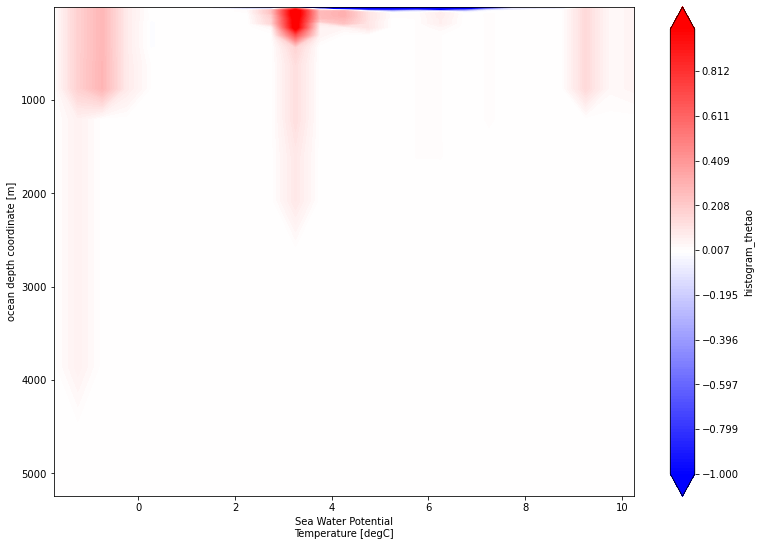

In [231]:
plt.figure(figsize=(13,9))
CAS_streamfunc = - ((CAS_adv_binned.cumsum('lev') - CAS_adv_binned.sum('lev'))).mean('year') / (cp * rho0 * 1e6)

CAS_streamfunc[:,:25].plot.contourf(yincrease=False,levels=150,cmap='bwr',vmin=-1,vmax=1)


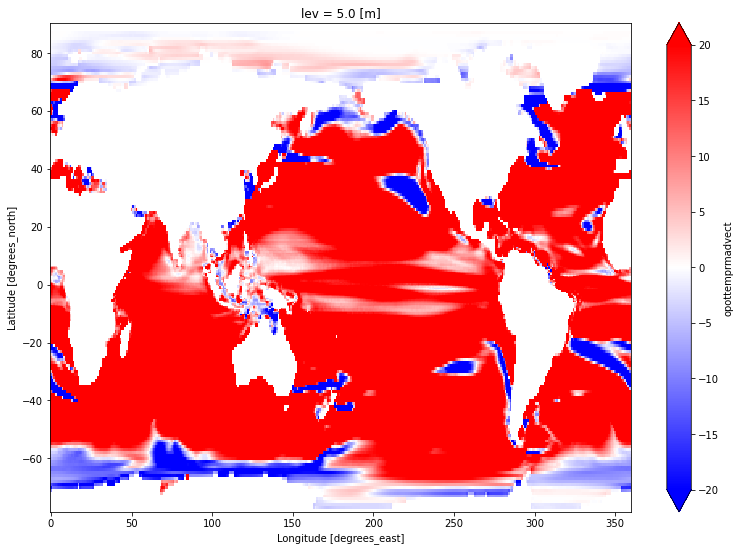

In [233]:
plt.figure(figsize=(13,9))
CAS_adv.mean('year').isel(lev=0).plot(cmap='bwr')

In [248]:
ACCCESS_CM2_faf_passiveheat_temp = load_faf_expt_tendencies('ACCESS-CM2', 'faf-passiveheat', 'temperature')

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/xarray/coding/times.py:144: SerializationWarning: Ambiguous reference date string: 950-01-01. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0950-01-01). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  warnings.warn(warning_msg, SerializationWarning)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/xarray/coding/times.py:673: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full nump

In [250]:
# Using the language of Abhi's 2021 SRC paper:

TEMP = ACCCESS_CM2_faf_passiveheat_temp[0][0] # Temperature field

TEND = ACCCESS_CM2_faf_passiveheat_temp[0][1] # Total tendency
ADV = ACCCESS_CM2_faf_passiveheat_temp[0][2]  # Tendency from residual mean advection 
MESO = ACCCESS_CM2_faf_passiveheat_temp[0][3] # Tendency from eddy advection
SUB = ACCCESS_CM2_faf_passiveheat_temp[0][4]  # Tendency from submesoscale advection
ISO = ACCCESS_CM2_faf_passiveheat_temp[0][5]  # Tendency from mesoscale diffusion
DIA = ACCCESS_CM2_faf_passiveheat_temp[0][6]  # Tendency from dianeautral mixing
SWP = ACCCESS_CM2_faf_passiveheat_temp[0][7]  # Shortwave absorption
SFC = ACCCESS_CM2_faf_passiveheat_temp[0][8]  # Net surface heat flux
surf_forc = SFC + SWP                         # The combined net surface heat flux and shortwave absorption terms
RES = TEND - ADV - ISO - DIA - surf_forc      # The tendency budget residual, as defined by Griffies OMIP budget (see notes below)

area = ACCCESS_CM2_faf_passiveheat_temp[1]    # Area of grid cells
volume = ACCCESS_CM2_faf_passiveheat_temp[2]  # Volume of grid cells

In [ ]:
# Tendency terms binned into temperature for ACCESS-CM2 faf-heat

TEND_binned = tendency_term_binning(TEND, TEMP, area, delta_T, min_T, max_T).load()           # Total tendency
ADV_binned = tendency_term_binning(ADV, TEMP, area, delta_T, min_T, max_T).load()             # Tendency from residual mean advection
# MESO_binned = tendency_term_binning(ISO, TEMP, area, delta_T, min_T, max_T).load()            # Tendency from net parameterized eddy advection
# SUB_binned = tendency_term_binning(SUB, TEMP, area, delta_T, min_T, max_T).load()             # Tendency from submesoscale eddy advection
ISO_binned = tendency_term_binning(ISO, TEMP, area, delta_T, min_T, max_T).load()             # Tendency from mesoscale diffusion
DIA_binned = tendency_term_binning(DIA, TEMP, area, delta_T, min_T, max_T).load()             # Tendency from dianeautral mixing
surf_forc_binned = tendency_term_binning(surf_forc, TEMP, area, delta_T, min_T, max_T).load() # Shortwave absorption + net surface heat flux

In [12]:
# Binned tendency terms for ACCESS-CM2 faf-heat streamfunctions

TEND_binned_streamfunc = tendency_term_binnned_streamfunction(TEND_binned, 'temperature')
ADV_binned_streamfunc = tendency_term_binnned_streamfunction(ADV_binned, 'temperature')
# MESO_binned_streamfunc = tendency_term_binnned_streamfunction(MESO_binned, 'temperature')
# SUB_binned_streamfunc = tendency_term_binnned_streamfunction(SUB_binned, 'temperature')
ISO_binned_streamfunc = tendency_term_binnned_streamfunction(ISO_binned, 'temperature')
DIA_binned_streamfunc = tendency_term_binnned_streamfunction(DIA_binned, 'temperature')
surf_forc_binned_streamfunc = tendency_term_binnned_streamfunction(surf_forc_binned, 'temperature')

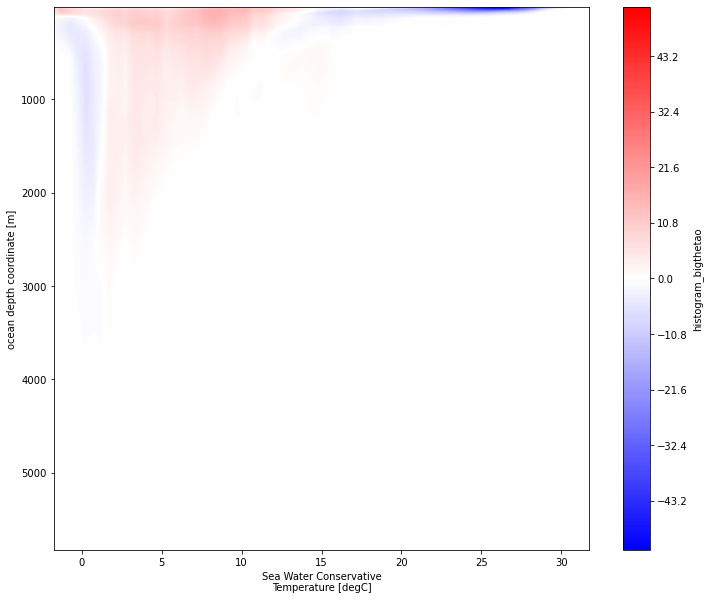

In [16]:
plt.figure(figsize=(12,10))
(ADV_binned_streamfunc).isel(year=slice(-20,None)).mean('year').sel(bigthetao_bin=slice(None,None)).sel(lev=slice(None,None)).plot.contourf(yincrease=False,
                                                                                                                                 levels=300,
                                                                                                                                 cmap='bwr')

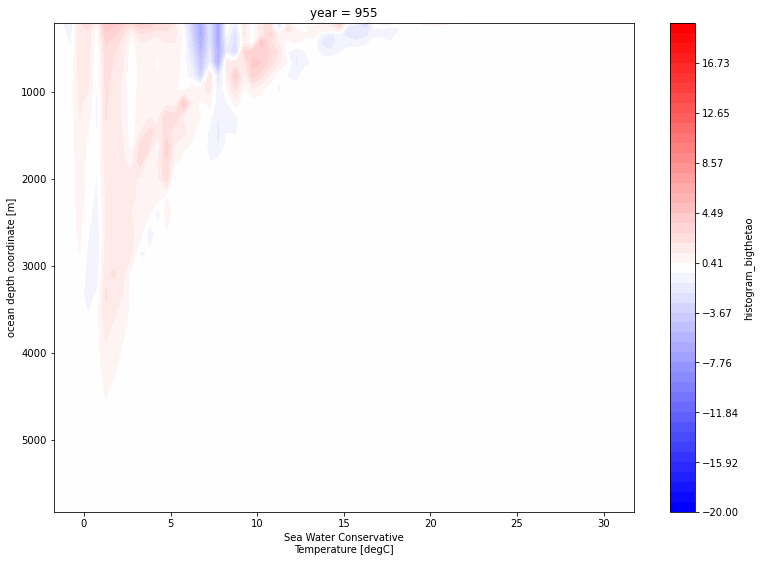

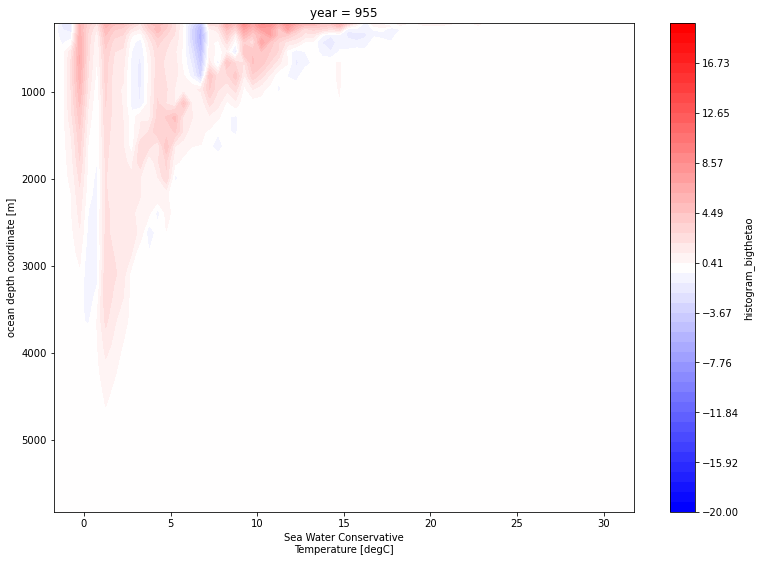

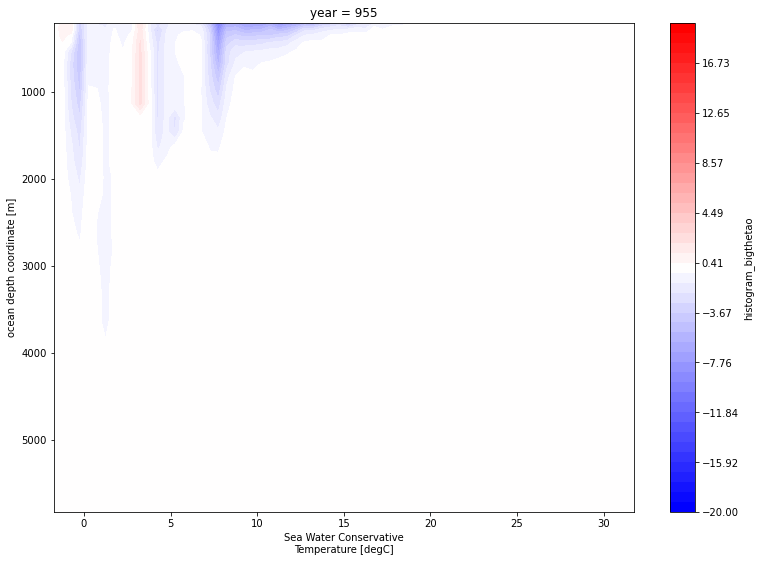

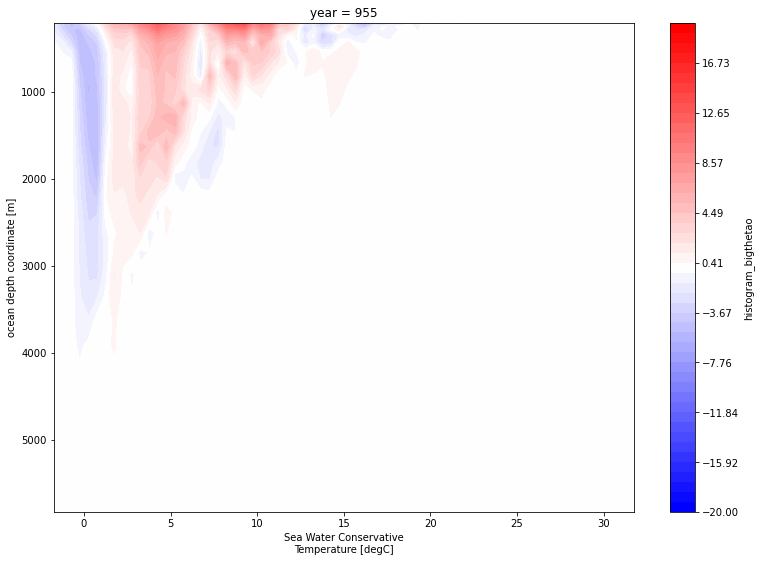

In [17]:
LHS = TEND_binned_streamfunc

RHS = ADV_binned_streamfunc + ISO_binned_streamfunc + DIA_binned_streamfunc + surf_forc_binned_streamfunc

# vmin = -1.7e13
# vmax = -vmin

vmin=-20
vmax=-vmin

year = 5

plt.figure(figsize=(13,9))
(LHS).isel(year=year).sel(lev=slice(200,None)).plot.contourf(yincrease=False,levels=50,cmap='bwr',
                                                         vmin = vmin,
                                                         vmax = vmax,
                                                         norm = TwoSlopeNorm(0))

plt.figure(figsize=(13,9))
(RHS).isel(year=year).sel(lev=slice(200,None)).plot.contourf(yincrease=False,levels=50,cmap='bwr',
                                                         vmin = vmin,
                                                         vmax = vmax,
                                                         norm = TwoSlopeNorm(0))

plt.figure(figsize=(13,9))
(LHS - RHS).isel(year=year).sel(lev=slice(200,None)).plot.contourf(yincrease=False,levels=50,cmap='bwr',
                                                         vmin = vmin,
                                                         vmax = vmax,
                                                         norm = TwoSlopeNorm(0))

plt.figure(figsize=(13,9))
(ADV_binned_streamfunc).isel(year=year).sel(lev=slice(200,None)).plot.contourf(yincrease=False,levels=50,cmap='bwr',
                                                         vmin = vmin,
                                                         vmax = vmax,
                                                         norm = TwoSlopeNorm(0))

Doesn't look like it closes very well at all... What am I missing?

As Ryan said in the cmip-wm-diagnostics channel, is this residual due to missing 'mixdownslope' and 'temp_sigma_diff' terms?
Is it due to the fact that we only have yearly snapshots/averages? Tendency from numerical mixing?
Hmph...

In [251]:
TEND_ACCESS = tendency_term_binning(TEND, TEMP, area, delta_T, min_T, max_T)
TEND_ACCESS

<xarray.DataArray 'histogram_bigthetao' (year: 70, lev: 50, bigthetao_bin: 68)>
dask.array<sum-aggregate, shape=(70, 50, 68), dtype=float32, chunksize=(1, 50, 68), chunktype=numpy.ndarray>
Coordinates:
  * year           (year) int64 950 951 952 953 954 ... 1015 1016 1017 1018 1019
  * lev            (lev) float64 5.0 15.0 25.0 ... 5.166e+03 5.499e+03 5.831e+03
  * bigthetao_bin  (bigthetao_bin) float64 -1.75 -1.25 -0.75 ... 31.25 31.75
Attributes:
    standard_name:  tendency_of_sea_water_conservative_temperature_expressed_...
    long_name:      Tendency of Sea Water Conservative Temperature Expressed ...

In [126]:
### Save as .nc file test ###

TEND_ACCESS = TEND_ACCESS.rename(TEND.name)
TEND_ACCESS.to_netcdf('/scratch/e14/mp2135/FAFMIP_binning/ACCESS-CM2_ocontemptend_binned.nc')

In [52]:
def fafpassive_TZstreamfuncs(models):
    
    streamfuncs = []
    
    for model in models:
        
        model_vars = load_faf_expt_tendencies(model, 'faf-passiveheat', 'temperature')
        
        temp = model_vars[0][0]
        adv = model_vars[0][2]
        area = model_vars[1]
        
        if area.size == 0:
            print (f'area field not available for {model}, therefore cannot bin in coordinate')
            continue
        
        streamfunc = tendency_term_binnned_streamfunction(tendency_term_binning(adv, temp, area, delta_T, min_T, max_T), 'temperature').load()
        
        streamfuncs.append(streamfunc)
        
        print(f'{model} done')
        
    return streamfuncs

In [53]:
fafpassive_streamfuncs = fafpassive_TZstreamfuncs(['ACCESS-CM2', 'CAS-ESM2-0', 'CanESM5', 'MPI-ESM1-2-HR', 'MRI-ESM2-0', 'CESM2', 'GFDL-ESM2M'])

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/xarray/coding/times.py:144: SerializationWarning: Ambiguous reference date string: 950-01-01. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0950-01-01). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  warnings.warn(warning_msg, SerializationWarning)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/xarray/coding/times.py:673: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full nump

volcello for ACCESS-CM2 not found


KeyboardInterrupt: 

In [191]:
CAS_fafpas = fafpassive_streamfuncs[1].load()

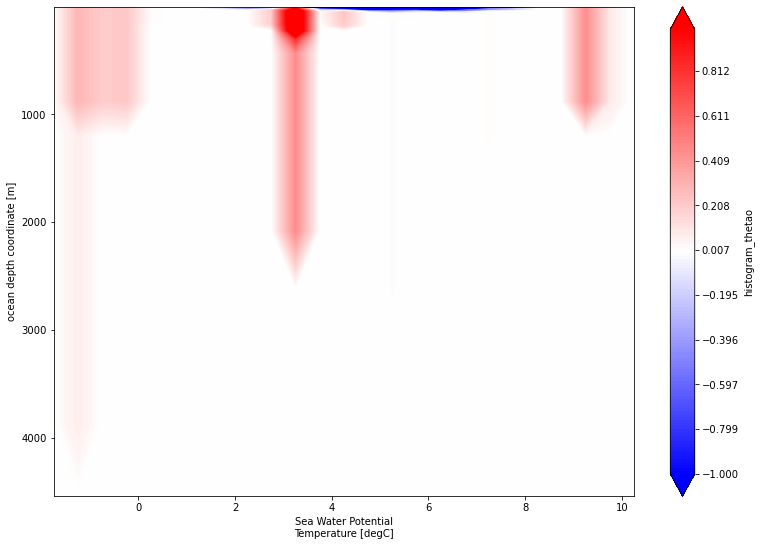

In [254]:
plt.figure(figsize=(13,9))
CAS_fafpas.isel(year=slice(-20,None)).mean('year')[:,:25].sel(lev=slice(None,5000)).plot.contourf(yincrease=False,levels=150,cmap='bwr',vmin=-1,vmax=1)

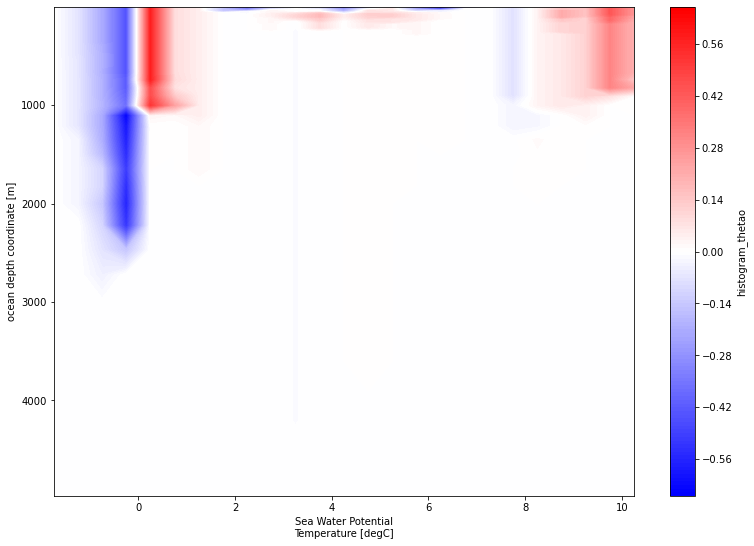

In [185]:
plt.figure(figsize=(13,9))
MRI_fafpas.isel(year=slice(-20,None)).mean('year')[:,:25].sel(lev=slice(None,5000)).plot.contourf(yincrease=False,levels=150,cmap='bwr')

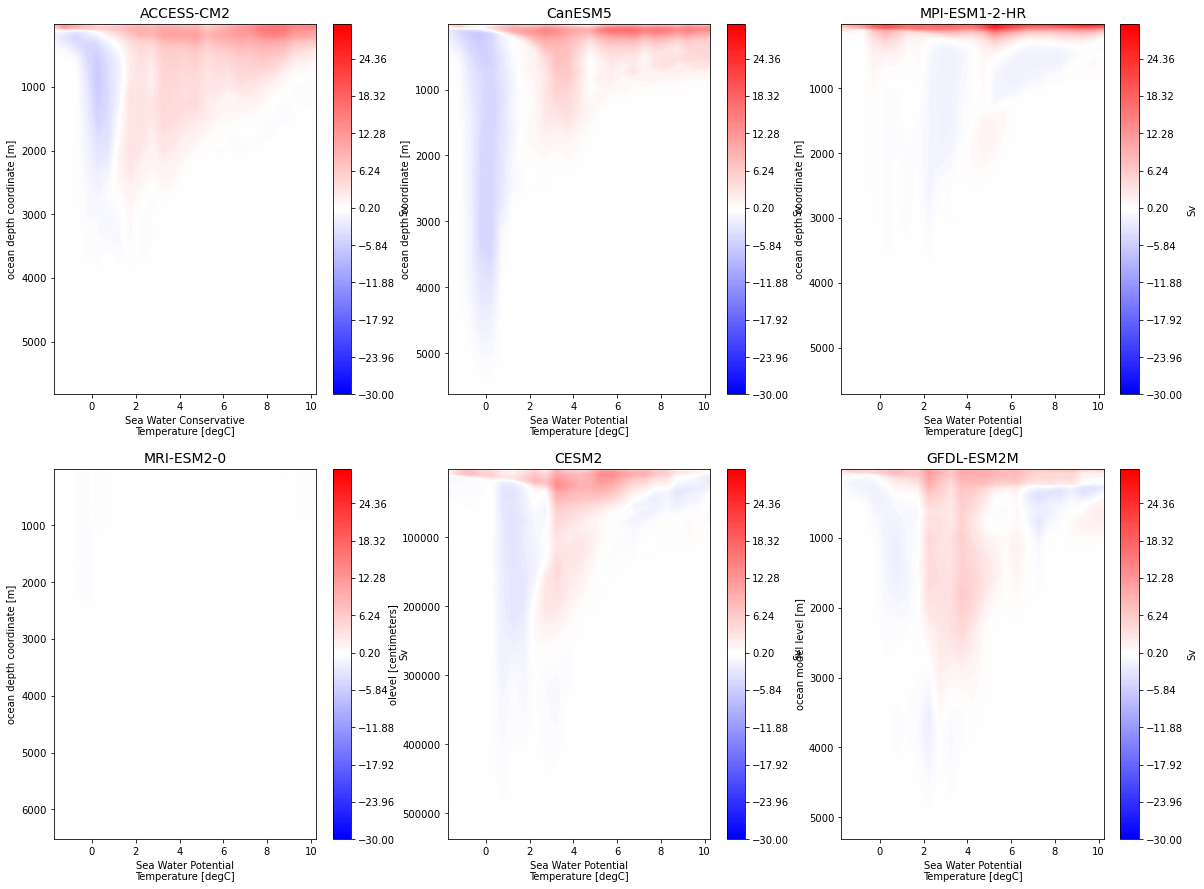

In [214]:
vmin = -30
vmax = -vmin

model = ['ACCESS-CM2', 'CanESM5', 'MPI-ESM1-2-HR', 'MRI-ESM2-0', 'CESM2', 'GFDL-ESM2M']

fig, ax = plt.subplots(figsize=(20,15), nrows=2, ncols=3)
# depth = 5000

for i in range(len(fafpassive_streamfuncs)):
    axis=ax.flatten()[i]
    (fafpassive_streamfuncs[i]).isel(year=slice(-20,None)).mean('year').sel(lev=slice(None,None))[:,:25].plot.contourf(ax=axis,yincrease=False,levels=150,cmap='bwr',
                                                                                                   vmin=vmin,
                                                                                                   vmax=vmax, cbar_kwargs={"label": "Sv"})
    axis.set_title(f'{model[i]}', fontsize=14)

In [94]:
def fafheat_TZstreamfuncs(models):
    
    streamfuncs = []
    
    for model in models:
        
        model_vars = load_faf_expt_tendencies(model, 'faf-heat', 'temperature')
        
        temp = model_vars[0][0]
        adv = model_vars[0][2]
        area = model_vars[1]
        
        if area.size == 0:
            print (f'area field not available for {model}, therefore cannot bin in coordinate')
            continue
        
        streamfunc = tendency_term_binnned_streamfunction(tendency_term_binning(adv, temp, area, delta_T, min_T, max_T), 'temperature').load()
        
        streamfuncs.append(streamfunc)
        
        print(f'{model} done')
        
    return streamfuncs

In [95]:
fafheat_streamfuncs = fafheat_TZstreamfuncs(['ACCESS-CM2', 'CAS-ESM2-0', 'CanESM5', 'MIROC6', 'MPI-ESM1-2-HR', 'MRI-ESM2-0', 'CESM2', 'GFDL-ESM2M'])

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/xarray/coding/times.py:144: SerializationWarning: Ambiguous reference date string: 950-01-01. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0950-01-01). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  warnings.warn(warning_msg, SerializationWarning)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/xarray/coding/times.py:673: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full nump

ACCESS-CM2 done
volcello for CAS-ESM2-0 not found
opottemppsmadvect term for CAS-ESM2-0 not found
rsdoabsorb term for CAS-ESM2-0 not found
CAS-ESM2-0 done
volcello for CanESM5 not found
opottemppsmadvect term for CanESM5 not found


/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/numpy/core/_methods.py:179: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/numpy/core/_methods.py:179: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


CanESM5 done
volcello for MIROC6 not found


/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/xarray/coding/times.py:673: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/xarray/coding/times.py:673: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, cal

opottemppsmadvect term for MIROC6 not found


/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/xarray/coding/times.py:673: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/xarray/coding/times.py:673: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, cal

hfds term for MIROC6 not found
rsdoabsorb term for MIROC6 not found
MIROC6 done
volcello for MPI-ESM1-2-HR not found
opottemppsmadvect term for MPI-ESM1-2-HR not found
MPI-ESM1-2-HR done
volcello for MRI-ESM2-0 not found


/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/dask/array/core.py:456: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/dask/array/core.py:456: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/dask/array/core.py:456: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/numpy/core/_methods.py:179: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, w

opottemppsmadvect term for MRI-ESM2-0 not found


/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/numpy/core/_methods.py:179: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/dask/array/core.py:456: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/dask/array/core.py:456: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/dask/array/core.py:456: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args

MRI-ESM2-0 done
volcello for CESM2 not found


/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/xarray/conventions.py:516: SerializationWarning: variable 'areacello' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/xarray/conventions.py:516: SerializationWarning: variable 'thetao' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/xarray/conventions.py:516: SerializationWarning: variable 'opottemptend' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/xarray/conventions.py:516: SerializationWarning: variable 'opottemprmadvect' has multiple fill values {1e+20, 1e+20}, decoding all values t

CESM2 done
volcello for GFDL-ESM2M not found


/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/numpy/core/_methods.py:179: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


GFDL-ESM2M done


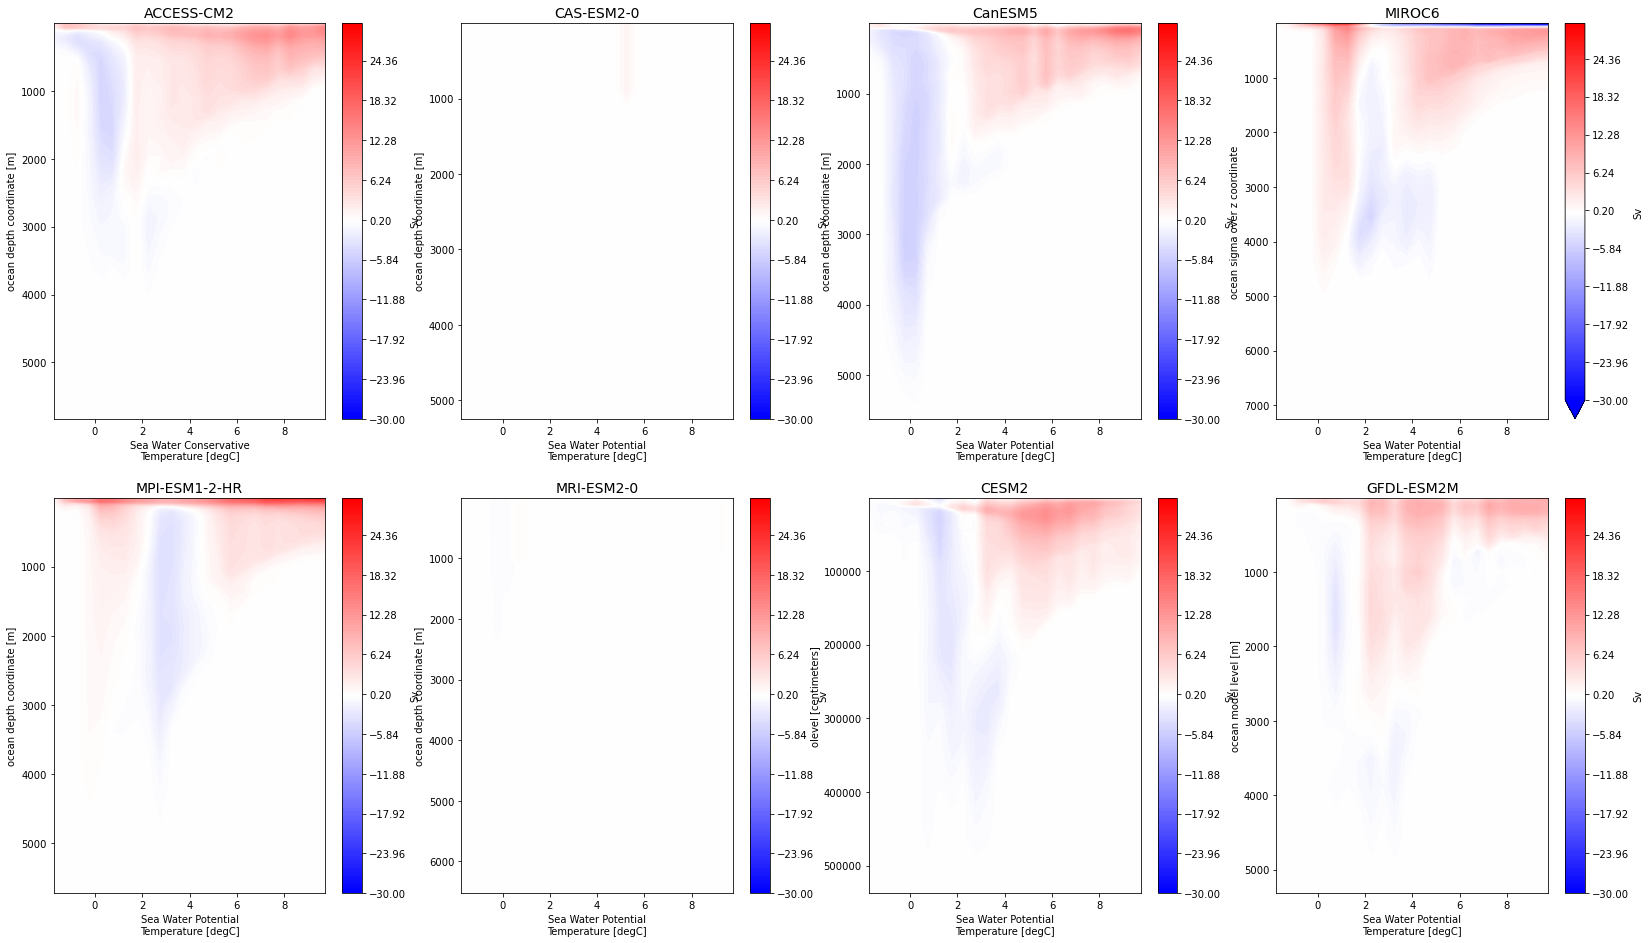

In [132]:
vmin = -30
vmax = -vmin

model = ['ACCESS-CM2', 'CAS-ESM2-0', 'CanESM5', 'MIROC6', 'MPI-ESM1-2-HR', 'MRI-ESM2-0', 'CESM2', 'GFDL-ESM2M']

fig, ax = plt.subplots(figsize=(28,16), nrows=2, ncols=4)

for i in range(len(fafheat_streamfuncs)):
    axis=ax.flatten()[i]
    (fafheat_streamfuncs[i]).isel(year=slice(-20,None)).mean('year').sel(lev=slice(None,None))[:,:24].plot.contourf(ax=axis,yincrease=False,levels=150,cmap='bwr',
                                                                                                   vmin=vmin,
                                                                                                   vmax=vmax, cbar_kwargs={"label": "Sv"})
    
    axis.set_title(f'{model[i]}', fontsize=14)

In [127]:
MIROC_temp = xr.open_mfdataset('/g/data/oi10/replicas/CMIP6/FAFMIP/MIROC/MIROC6/faf-heat/r1i1p1f1/Omon/thetao/gn/v20190311/*.nc').groupby('time.year').mean('time',keep_attrs=True)['thetao'].isel(year=slice(1,None))
MIROC_adv = xr.open_mfdataset('/g/data/oi10/replicas/CMIP6/FAFMIP/MIROC/MIROC6/faf-heat/r1i1p1f1/Oyr/opottemprmadvect/gn/v20200918/*.nc').groupby('time.year').mean('time',keep_attrs=True)['opottemprmadvect']
MIROC_area = xr.open_mfdataset('/g/data/oi10/replicas/CMIP6/FAFMIP/MIROC/MIROC6/faf-heat/r1i1p1f1/Ofx/areacello/gn/v20190311/*.nc')['areacello']

MIROC_adv_streamfunc = tendency_term_binnned_streamfunction(tendency_term_binning(MIROC_adv, MIROC_temp, MIROC_area, delta_T, min_T, max_T), 'temperature').load()

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/xarray/coding/times.py:673: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/numpy/core/_methods.py:179: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/xarray/coding/ti

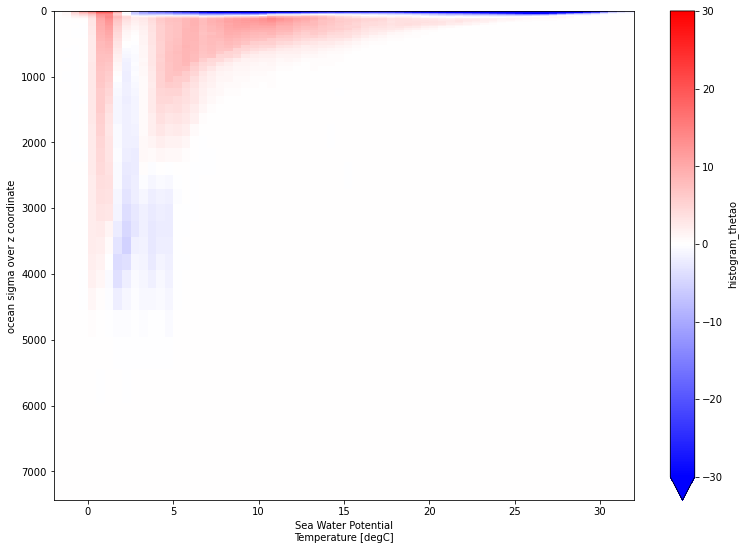

In [149]:
plt.figure(figsize=(13,9))

MIROC_adv_streamfunc.isel(year=slice(-20,None)).mean('year').plot(yincrease=False,cmap='bwr', vmin=-30, vmax=30)

In [129]:
GFDL_temp = xr.open_mfdataset('/g/data/oi10/replicas/CMIP6/FAFMIP/NOAA-GFDL/GFDL-ESM2M/faf-heat/r1i1p1f1/Omon/thetao/gn/v20180701/*.nc').groupby('time.year').mean('time',keep_attrs=True)['thetao']
GFDL_adv = xr.open_mfdataset('/g/data/oi10/replicas/CMIP6/FAFMIP/NOAA-GFDL/GFDL-ESM2M/faf-heat/r1i1p1f1/Oyr/opottemprmadvect/gn/v20180701/*.nc').groupby('time.year').mean('time',keep_attrs=True)['opottemprmadvect']
GFDL_area = xr.open_mfdataset('/g/data/oi10/replicas/CMIP6/FAFMIP/NOAA-GFDL/GFDL-ESM2M/faf-passiveheat/r1i1p1f1/Ofx/areacello/gn/v20180701/*.nc')['areacello']

GFDL_adv_streamfunc = tendency_term_binnned_streamfunction(tendency_term_binning(GFDL_adv, GFDL_temp, GFDL_area, delta_T, min_T, max_T), 'temperature').load()

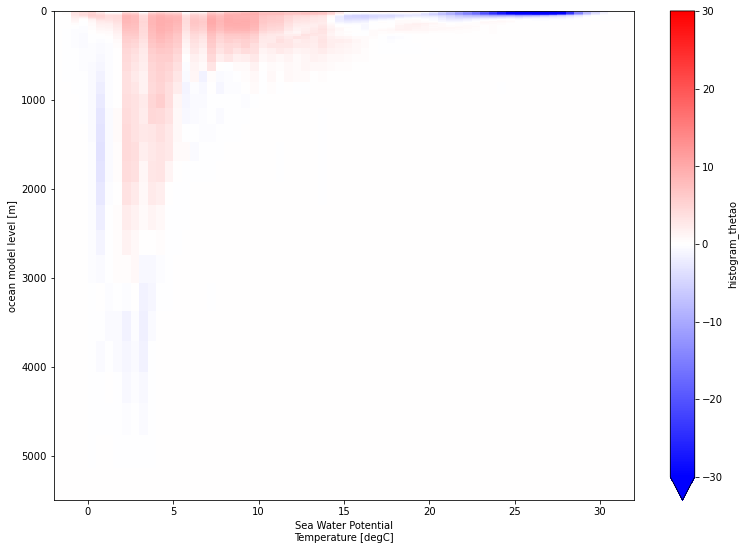

In [133]:
plt.figure(figsize=(13,9))

GFDL_adv_streamfunc.isel(year=slice(-20,None)).mean('year').plot(yincrease=False,cmap='bwr', vmin=-30, vmax=30)

In [147]:
GFDL_temp_pas = xr.open_mfdataset('/g/data/oi10/replicas/CMIP6/FAFMIP/NOAA-GFDL/GFDL-ESM2M/faf-passiveheat/r1i1p1f1/Omon/thetao/gn/v20180701/*.nc').groupby('time.year').mean('time',keep_attrs=True)['thetao']
GFDL_adv_pas = xr.open_mfdataset('/g/data/oi10/replicas/CMIP6/FAFMIP/NOAA-GFDL/GFDL-ESM2M/faf-passiveheat/r1i1p1f1/Oyr/opottemprmadvect/gn/v20180701/*.nc').groupby('time.year').mean('time',keep_attrs=True)['opottemprmadvect']
GFDL_area = xr.open_mfdataset('/g/data/oi10/replicas/CMIP6/FAFMIP/NOAA-GFDL/GFDL-ESM2M/faf-passiveheat/r1i1p1f1/Ofx/areacello/gn/v20180701/*.nc')['areacello']

GFDL_adv_pas_streamfunc = tendency_term_binnned_streamfunction(tendency_term_binning(GFDL_adv_pas, GFDL_temp_pas, GFDL_area, delta_T, min_T, max_T), 'temperature').load()

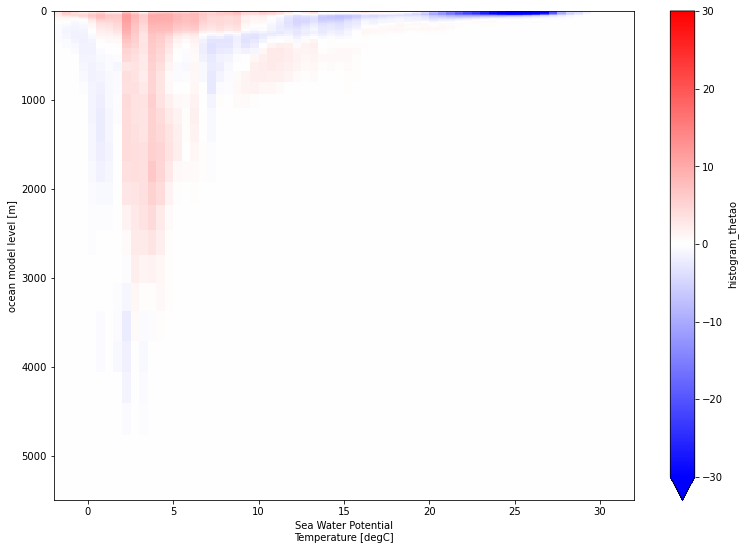

In [148]:
plt.figure(figsize=(13,9))

GFDL_adv_pas_streamfunc.isel(year=slice(-20,None)).mean('year').plot(yincrease=False,cmap='bwr', vmin=-30, vmax=30)

### Go through all FAFMIP runs available on /g/data, bin tendency terms in T-z or S-z, and save as .nc files to my /g/data

I want a function that:

- Loads in the available tendency terms for a given model for a given FAFMIP experiment (use earlier function);
- Bins each tendency term in T-z/S-z space (use earlier function);
- Gives the binned tendency term the name of the original tendency term (for nice .nc saving); and
- Saves the binned tendency term at a given save_path, using the name of the tendency term to save nicely named files.

Then I can just apply this function looped over all the available models looped over all the FAFMIP experiments :-).

In [8]:
def save_binned_tendencies(model_name, faf_expt_name, variable_type, save_path_root):
    '''
    DESCRIPTION:
    Load tendency terms, bin tendency terms, save tendency terms!
    ---
    OPTIONS:
    ---
    model_name:     
    faf_expt_name:
    variable_type:
    save_path_root:
    ---
    '''
    
    ### Load in terms ###
    available_faf_terms = load_faf_expt_tendencies(model_name, faf_expt_name, variable_type)
    
    coordinate = available_faf_terms[0][0]
    tendency_terms = available_faf_terms[0][1:]
    area = available_faf_terms[1]
    
    ### Do T-z/S-z binning ###
    
    if variable_type == 'temperature':
        delta_coord = delta_T
        min_coord = min_T
        max_coord = max_T
        
    elif variable_type == 'salinity':
        delta_coord = delta_S
        min_coord = min_S
        max_coord = max_S
    
    
    for term in tendency_terms:
        
        if term.size == 0:
            # See try-except syntax in load_faf_expt_tendencies function
            print('term not provided on NCI')
            
        else:
            term_name = term.name

            term_binned = tendency_term_binning(term, coordinate, area, delta_coord, min_coord, max_coord)

            term_binned = term_binned.rename(term_name)

            save_path = save_path_root + '/' + model_name + '/' + faf_expt_name + '/' + term_name + '_binned.nc'

            term_binned.to_netcdf(save_path)

In [9]:
models = ['ACCESS-CM2', 'CAS-ESM2-0', 'CanESM5', 'FGOALS-g3', 'MIROC6', 'MPI-ESM1-2-HR', 'MRI-ESM2-0', 'CESM2', 'GFDL-ESM2M']
faf_experiments = ['faf-passiveheat', 'faf-heat', 'faf-all', 'faf-water', 'faf-stress']
binning_coordinates = ['temperature', 'salinity']

save_root_path = '/g/data/e14/mp2135/FAFMIP_binned'

for model in models:
    for experiment in faf_experiments:
        for coordinate in binning_coordinates:
#             save_binned_tendencies(model, experiment, coordinate, save_path_root)